### 1. การติดตั้งและ Import Library

- ส่วนนี้คือการติดตั้ง library ที่จำเป็น เช่น unsloth, transformers, trl
- transformers คือ library หลักของ HuggingFace ที่มีโมเดล NLP และ Vision ที่ pretrained มาแล้ว
- trl เอาไว้ train/fine-tune โมเดลโดยใช้เทคนิค reinforcement learning หรือ supervised fine-tuning

In [1]:
# # 1) สร้างและเข้า env
# python -m venv .venv
# # Windows: .\.venv\Scripts\Activate.ps1
# # Linux/macOS: source .venv/bin/activate
# python -m pip install -U pip

# # 2) ล้างของเก่า
# pip uninstall -y torch torchvision torchaudio xformers

# # 3) ติดตั้ง PyTorch + CUDA runtime (เลือก 1 ทาง)
# pip install --index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio
# # หรือใช้คำสั่งที่หน้า Get Started ให้มาสำหรับเวอร์ชัน CUDA ล่าสุดของคุณ

# # 4) xformers (เลือกจากล้อที่เข้ากัน)
# pip install xformers -f https://download.pytorch.org/whl/xformers/

# # 5) Unsloth
# pip install unsloth

ตรวจสอบว่า PyTorch เห็น GPU:

In [2]:
import torch, platform

print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Python: 3.10.6
Torch: 2.8.0+cu129
Built with CUDA: 12.9
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


### 2. โหลดโมเดล Vision-Language

- โหลดโมเดล Qwen2.5-VL (Vision-Language model) ที่สามารถเข้าใจ รูปภาพ + ข้อความ
- tokenizer ทำหน้าที่แปลงข้อความเป็นตัวเลข (tokens)
- load_in_4bit=True → ใช้ quantization 4-bit เพื่อลดขนาดโมเดลและประหยัด GPU memory

In [7]:
import unsloth
import torch, platform
from unsloth import FastVisionModel
import torch
import os
os.environ["UNSLOTH_IS_PRESENT"] = "1"

# 🧠 Load MedGemma in 4-bit Unsloth mode
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/medgemma-4b-it-unsloth-bnb-4bit",  # ✅ your new model
    load_in_4bit = True,                         # use 4-bit quantization (QLoRA ready)
    use_gradient_checkpointing = "unsloth",      # save GPU memory while training
)

# 🐉 Put the model into training or inference mode
FastVisionModel.for_training(model)   # or .for_inference(model) later
print("✅ MedGemma-4B-IT Unsloth 4bit model loaded successfully!")
print(f"Model dtype: {next(model.parameters()).dtype}")
print(f"Device: {model.device}")


==((====))==  Unsloth 2025.9.11: Fast Gemma3 patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.6. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3 does not support SDPA - switching to fast eager.
✅ MedGemma-4B-IT Unsloth 4bit model loaded successfully!
Model dtype: torch.bfloat16
Device: cuda:0


### 3. เพิ่ม LoRA (Low-Rank Adaptation)

- ใช้ LoRA (Low-Rank Adaptation) เพื่อ fine-tune โมเดลเฉพาะบางพารามิเตอร์ แทนที่จะ train ใหม่ทั้งหมด
- เราสามารถเลือกว่าจะฝึกเฉพาะ vision part หรือ language part ของโมเดลได้

In [8]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,    # ✅ ให้สายภาพเรียนรู้พยาธิสภาพ/feature เฉพาะทาง
    finetune_language_layers   = False,   # ✅ รอบแรกกัน drift ภาษา (ยัง generate ได้ เพราะ head/weights ถูกใช้ตอน infer)
    finetune_attention_modules = True,    # ✅ สำคัญมากสำหรับ cross-modal alignment (ภาพ↔ข้อความ)
    finetune_mlp_modules       = False,   # ✅ ลดพารามิเตอร์ช่วงเริ่ม กัน overfit / catastrophic forgetting

    r = 16,                # ✅ เริ่มที่ 16; ถ้า underfit ค่อยขยับ 32 พร้อม rsLoRA
    lora_alpha = 16,       # ✅ อย่างน้อยเท่ากับ r ตามคำแนะนำ Unsloth
    lora_dropout = 0.15,   # ✅ ช่วยกัน overfit/โหมดเดิม (เช่นตอบ "Normal" รัว ๆ)
    bias = "none",
    random_state = 3407,

    use_rslora = True,     # ✅ เสถียรกับ rank สูง/งานยาก
    loftq_config = None,   # ✅ ถ้าเทรน 4-bit แนะนำเปิด LoftQ โปรไฟล์ C เพื่อคุณภาพ
    # target_modules = ["q_proj","k_proj","v_proj","o_proj"],  # ↔ ถ้าจะเริ่มเฉพาะ attention เท่านั้น ค่อยปลดคอมเมนต์
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.15.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [3]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

# # แบ่ง train/test (30%) ก่อน
# splits = hf.train_test_split(test_size=0.3, seed=42, shuffle=True)
# train_hf = splits["train"]
# tmp_hf   = splits["test"]

# # แบ่ง tmp ให้เป็น val/test อย่างละครึ่ง → ได้ 15/15
# vt = tmp_hf.train_test_split(test_size=0.5, seed=42, shuffle=True)
# val_hf  = vt["train"]
# test_hf = vt["test"]
splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

Total dataset size : 6,085
Train set size     : 5,172 (85.00%)
Test set size      : 913 (15.00%)


In [6]:
# train_hf

In [7]:
# val_hf

In [4]:
n = len(train_hf)
k = 6
fold_size = n // k

folds = []
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size if i < k - 1 else n
    fold = train_hf.select(range(start, end))
    folds.append(fold)

# เลือก fold ที่ต้องการรวม (เช่น 0-4)
# selected_folds = [1, 2, 3, 4, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
# selected_folds = [0, 2, 3, 4, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
# selected_folds = [0, 1, 3, 4, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
# selected_folds = [0, 1, 2, 4, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
# selected_folds = [0, 1, 2, 3, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
selected_folds = [0, 1, 2, 3, 4]        # ← แก้เลขใน list นี้ได้ตามต้องการ

from datasets import concatenate_datasets
train_selected = concatenate_datasets([folds[i] for i in selected_folds])
# idx_selected = 0                        # ← แก้เลขในนี้ได้ตามต้องการ
# idx_selected = 1                        # ← แก้เลขในนี้ได้ตามต้องการ
# idx_selected = 2                        # ← แก้เลขในนี้ได้ตามต้องการ
# idx_selected = 3                        # ← แก้เลขในนี้ได้ตามต้องการ
# idx_selected = 4                        # ← แก้เลขในนี้ได้ตามต้องการ
idx_selected = 5                        # ← แก้เลขในนี้ได้ตามต้องการ
val_selected = folds[idx_selected]            

print(f"Total train_hf : {n}")
print(f"Each fold size : {fold_size}")
print(f"Selected folds : {selected_folds}")
print(f"Combined size  : {len(train_selected)}")

Total train_hf : 5172
Each fold size : 862
Selected folds : [0, 1, 2, 3, 4]
Combined size  : 4310


#### Main : dataset ของเราเอง

In [5]:
instruction = (
    "You are an expert radiologist. "
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive."
)

def convert_to_conversation(sample):
    cls_name = sample["__class__"]
    description = sample["text"]

    answer = f"Class: {cls_name}\nExplanation: {description}"

    conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a medical image interpretation assistant."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]}
            ]
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": answer}]
        }
    ]

    return {"messages": conversation}

# Convert your datasets
converted_dataset      = [convert_to_conversation(sample) for sample in train_selected]
converted_dataset_val  = [convert_to_conversation(sample) for sample in val_selected]
converted_dataset[0]
# test_ds       = [convert_to_conversation(sample) for sample in test_hf]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a medical image interpretation assistant.'}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiologist. Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=450x450>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Class: Normal\nExplanation: Normal'}]}]}

In [10]:
# train_ds[0]

In [6]:
import re
import numpy as np
from evaluate import load

# โหลด metric BLEU เพียงครั้งเดียว
bleu = load("bleu")

# รายชื่อคลาสที่อนุญาต
ALLOWED_CLASSES = {
    "Chest_Changes",
    "Degenerative_Infectious",
    "Higher_Density",
    "Inflammatory_Pneumonia",
    "Lower_Density",
    "Mediastinal_Changes",
    "Normal",
    "Obstructive",
}

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # ===== ฟังก์ชันย่อยภายในสำหรับดึงชื่อคลาส =====
    def extract_class(text: str):
        """ดึงชื่อคลาสจากข้อความ (ถ้ามี)"""
        if not isinstance(text, str):
            return None
        for cls in ALLOWED_CLASSES:
            # ใช้ regex ค้นชื่อคลาสแบบ exact (ไม่สนข้อความอื่นรอบ ๆ)
            if re.search(rf"\b{re.escape(cls)}\b", text):
                return cls
        return None
    # ===============================================

    # แปลง token IDs เป็นข้อความ
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ดึงชื่อคลาสจาก pred และ label
    pred_classes = [extract_class(p) for p in preds]
    label_classes = [extract_class(l) for l in labels]

    # คำนวณ accuracy — นับถูกถ้าชื่อคลาสตรงกัน
    correct, total = 0, 0
    for p_cls, l_cls in zip(pred_classes, label_classes):
        if l_cls is not None:
            total += 1
            if p_cls == l_cls:
                correct += 1
    acc = correct / total if total > 0 else 0.0

    # คำนวณ BLEU score (ความใกล้เคียงข้อความ)
    bleu_score = bleu.compute(
        predictions=[[p.split()] for p in preds],
        references=[[[l.split()]] for l in labels]
    )["bleu"]

    # คืนค่า metric ทั้งคู่
    return {
        "eval_accuracy": acc,
        "eval_bleu": bleu_score,
    }

In [7]:
from unsloth import is_bf16_supported, FastVisionModel
from unsloth.trainer import UnslothVisionDataCollator
from transformers import EarlyStoppingCallback, TrainerCallback
from trl import SFTTrainer, SFTConfig
import torch, math, random
import numpy as np
from collections import Counter
from typing import List, Dict, Any
import re
import unicodedata

#1 FOLD

In [13]:
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        # ===== core =====
        per_device_train_batch_size = 2,
        per_device_eval_batch_size  = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        seed = 3407,

        # ===== Eval =====
        eval_strategy = "steps",
        eval_steps = 15,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        # ===== Precision / dtype =====
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        # ===== Optimization =====
        learning_rate = 2e-4,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        max_grad_norm = 1.0,

        # ===== Dataloader (สำคัญ) =====
        dataloader_num_workers = 0,      # 👈 ปิด multi-worker กันปัญหา pickle
        dataloader_pin_memory = True,
        dataloader_drop_last = False,
        # อย่าใส่ dataloader_prefetch_factor / persistent_workers เมื่อ num_workers=0

        # ===== Logging / Checkpoint IO =====
        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        # ===== Output =====
        output_dir = "outputs",

        # ===== Vision finetuning (required) =====
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,            # 👈 กันปัญหา pickle ตอน map/prepare (ถ้ามี)
        max_seq_length = 1024,

        # ===== Memory saver =====
        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
    # เรา "ไม่" ใช้ compute_metrics ที่ระดับ SFTTrainer ตรง ๆ
    # เพราะ VLM+generate มักชนกับ _pad_across_processes; จึงย้ายไป callback
)

trainer.predict_with_generate = True
trainer.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

In [14]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 3,981,312 of 4,304,060,784 (0.09% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
15,3.970100,3.868225
30,3.822000,3.846256


Unsloth: Not an error, but Gemma3ForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [15]:

# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 3.8698938210805256
Final Eval Loss for this fold = 3.8463
All metrics: {'train_runtime': 2741.4115, 'train_samples_per_second': 0.088, 'train_steps_per_second': 0.011, 'total_flos': 2279819013226560.0, 'train_loss': 3.8698938210805256, 'epoch': 0.05568445475638051}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.8867,1.012692,0.000000,0.001856,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0493,3.668857,0.000040,0.003712,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.9013,1.961649,0.000080,0.005568,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.8475,0.853276,0.000120,0.007425,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.7684,0.466547,0.000160,0.009281,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.8028,0.741665,0.000200,0.011137,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3.7606,0.978451,0.000192,0.012993,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.8255,0.746295,0.000184,0.014849,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.9226,2.041862,0.000176,0.016705,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.0896,0.872158,0.000168,0.018561,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


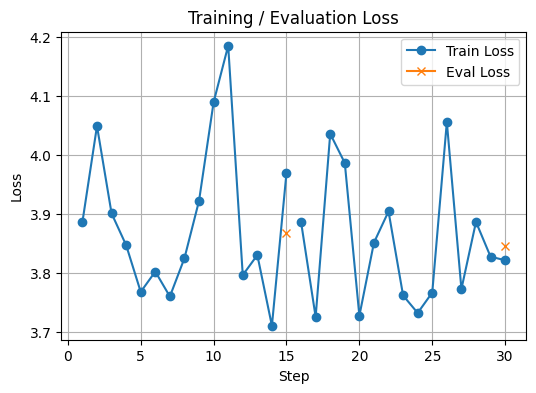

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [29]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx5_20251017_005934


In [ ]:
lll

#2

In [30]:
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FastVisionModel.for_training(model)

trainer2 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        # ===== core =====
        per_device_train_batch_size = 2,
        per_device_eval_batch_size  = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 6,
        max_steps = 60,
        seed = 3407,

        # ===== Eval =====
        eval_strategy = "steps",
        eval_steps = 30,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        # ===== Precision / dtype =====
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        # ===== Optimization =====
        learning_rate = 1e-4,
        optim = "adamw_torch",
        weight_decay = 0.05,
        lr_scheduler_type = "cosine",
        max_grad_norm = 0.5,

        # ===== Dataloader (สำคัญ) =====
        dataloader_num_workers = 0,      # 👈 ปิด multi-worker กันปัญหา pickle
        dataloader_pin_memory = True,
        dataloader_drop_last = False,
        # อย่าใส่ dataloader_prefetch_factor / persistent_workers เมื่อ num_workers=0

        # ===== Logging / Checkpoint IO =====
        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        # ===== Output =====
        output_dir = "outputs",

        # ===== Vision finetuning (required) =====
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,            # 👈 กันปัญหา pickle ตอน map/prepare (ถ้ามี)
        max_seq_length = 1024,

        # ===== Memory saver =====
        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
    # เรา "ไม่" ใช้ compute_metrics ที่ระดับ SFTTrainer ตรง ๆ
    # เพราะ VLM+generate มักชนกับ _pad_across_processes; จึงย้ายไป callback
)

trainer2.predict_with_generate = True
trainer2.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

In [31]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer2)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 3,981,312 of 4,304,060,784 (0.09% trained)


Step,Training Loss,Validation Loss
30,3.771500,3.783091
60,3.653500,3.751913


In [32]:

# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer2.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 3.780783307552338
Final Eval Loss for this fold = 3.7519
All metrics: {'train_runtime': 3467.948, 'train_samples_per_second': 0.138, 'train_steps_per_second': 0.017, 'total_flos': 4568345441761920.0, 'train_loss': 3.780783307552338, 'epoch': 0.11136890951276102}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.8338,2.726243,0.000000e+00,0.001856,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.9868,0.894874,1.666667e-05,0.003712,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.8363,5.265305,3.333333e-05,0.005568,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.7825,0.662139,5.000000e-05,0.007425,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.7075,0.680872,6.666667e-05,0.009281,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,3.6154,0.857829,7.596123e-07,0.107657,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,3.6655,0.866230,3.380821e-07,0.109513,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,3.6535,1.068283,8.459209e-08,0.111369,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,0.111369,60,3.751913,901.5476,0.956,0.24,NaN,NaN,NaN,NaN,NaN


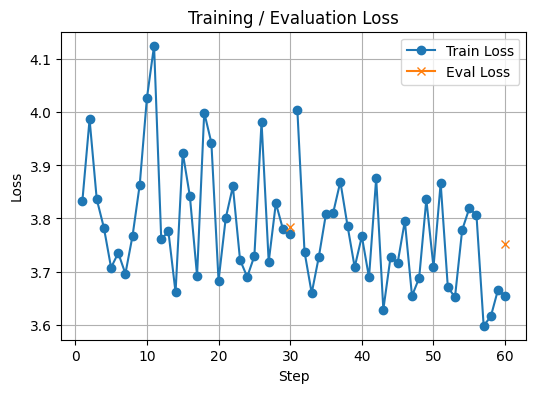

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer2.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:

from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /unsloth/medgemma-4b-it-unsloth-bnb-4bit/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000160F087BB80>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 451b2559-0816-44f9-a84f-0773ecb9a49b)')' thrown while requesting HEAD https://huggingface.co/unsloth/medgemma-4b-it-unsloth-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /unsloth/medgemma-4b-it-unsloth-bnb-4bit/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000160F087BDC0>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: cfae9f59-f234-471e-8489-b9b0e99e9e0e)')' thrown while requesting HEAD https://huggingface.co

✅ Model saved to: lora_model_val_idx5_20251017_094312


In [ ]:
lll

#3 FOLD

In [34]:
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FastVisionModel.for_training(model)

trainer3 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        # ===== core =====
        per_device_train_batch_size = 2,
        per_device_eval_batch_size  = 8,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        seed = 3407,

        # ===== Eval =====
        eval_strategy = "steps",
        eval_steps = 10,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 1,

        # ===== Precision / dtype =====
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        # ===== Optimization =====
        learning_rate = 3e-4,
        optim = "adamw_8bit",
        weight_decay = 0.05,
        lr_scheduler_type = "cosine_with_restarts",
        max_grad_norm = 1.0,

        # ===== Dataloader (สำคัญ) =====
        dataloader_num_workers = 0,      # 👈 ปิด multi-worker กันปัญหา pickle
        dataloader_pin_memory = True,
        dataloader_drop_last = False,
        # อย่าใส่ dataloader_prefetch_factor / persistent_workers เมื่อ num_workers=0

        # ===== Logging / Checkpoint IO =====
        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        # ===== Output =====
        output_dir = "outputs",

        # ===== Vision finetuning (required) =====
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,            # 👈 กันปัญหา pickle ตอน map/prepare (ถ้ามี)
        max_seq_length = 1536,

        # ===== Memory saver =====
        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
    # เรา "ไม่" ใช้ compute_metrics ที่ระดับ SFTTrainer ตรง ๆ
    # เพราะ VLM+generate มักชนกับ _pad_across_processes; จึงย้ายไป callback
)

trainer3.predict_with_generate = True
trainer3.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

In [35]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer3)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 3,981,312 of 4,304,060,784 (0.09% trained)


Step,Training Loss,Validation Loss
10,3.895900,3.690454
20,3.542000,3.644702
30,3.600500,3.625195


In [36]:

# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer3.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 3.6686484177907306
Final Eval Loss for this fold = 3.6252
All metrics: {'train_runtime': 3663.416, 'train_samples_per_second': 0.066, 'train_steps_per_second': 0.008, 'total_flos': 2279819013226560.0, 'train_loss': 3.6686484177907306, 'epoch': 0.05568445475638051}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.7327,0.654916,0.000000,0.001856,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.8892,0.693035,0.000060,0.003712,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.7259,0.961257,0.000120,0.005568,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.6798,0.455662,0.000180,0.007425,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.6211,0.599120,0.000240,0.009281,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.6199,1.221304,0.000300,0.011137,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3.5846,0.899783,0.000299,0.012993,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.6269,0.845412,0.000295,0.014849,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.7157,0.784854,0.000289,0.016705,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.8959,1.719449,0.000281,0.018561,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


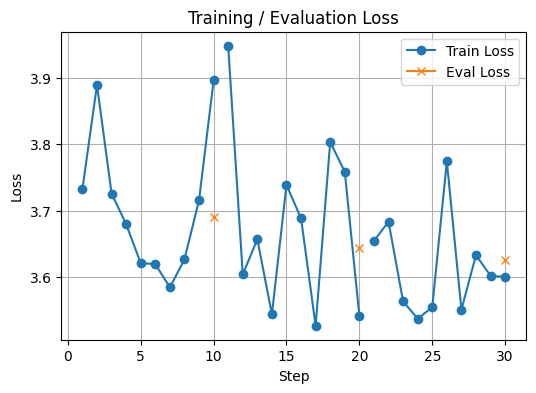

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer3.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [38]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx5_20251017_025945


#4 FOLD


In [39]:
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FastVisionModel.for_training(model)

trainer4 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        # ===== core =====
        per_device_train_batch_size = 1,
        per_device_eval_batch_size  = 2,
        gradient_accumulation_steps = 8,
        warmup_steps = 8,
        max_steps = 40,
        seed = 3407,

        # ===== Eval =====
        eval_strategy = "steps",
        eval_steps = 15,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        # ===== Precision / dtype =====
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        # ===== Optimization =====
        learning_rate = 1e-4,
        optim = "adamw_8bit",
        weight_decay = 0.05,
        lr_scheduler_type = "polynomial",
        max_grad_norm = 1.0,

        # ===== Dataloader (สำคัญ) =====
        dataloader_num_workers = 0,      # 👈 ปิด multi-worker กันปัญหา pickle
        dataloader_pin_memory = True,
        dataloader_drop_last = False,
        # อย่าใส่ dataloader_prefetch_factor / persistent_workers เมื่อ num_workers=0

        # ===== Logging / Checkpoint IO =====
        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        # ===== Output =====
        output_dir = "outputs",

        # ===== Vision finetuning (required) =====
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,            # 👈 กันปัญหา pickle ตอน map/prepare (ถ้ามี)
        max_seq_length = 1024,

        # ===== Memory saver =====
        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
    # เรา "ไม่" ใช้ compute_metrics ที่ระดับ SFTTrainer ตรง ๆ
    # เพราะ VLM+generate มักชนกับ _pad_across_processes; จึงย้ายไป callback
)

trainer4.predict_with_generate = True
trainer4.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

In [40]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer4)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 40
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 3,981,312 of 4,304,060,784 (0.09% trained)


Step,Training Loss,Validation Loss
15,3.635500,3.564521
30,3.530400,3.527258


In [41]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer4.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 3.555196923017502
Final Eval Loss for this fold = 3.5273
All metrics: {'train_runtime': 2892.3081, 'train_samples_per_second': 0.111, 'train_steps_per_second': 0.014, 'total_flos': 2952249160448640.0, 'train_loss': 3.555196923017502, 'epoch': 0.07424593967517401}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.5766,0.690043,0.000000,0.001856,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.7408,1.035660,0.000013,0.003712,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5711,0.851761,0.000025,0.005568,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.5544,0.677143,0.000038,0.007425,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.5169,0.742296,0.000050,0.009281,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.4847,0.805853,0.000063,0.011137,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3.4918,0.593382,0.000075,0.012993,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.5340,0.590295,0.000087,0.014849,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.5956,0.764981,0.000100,0.016705,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.7670,0.685082,0.000097,0.018561,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


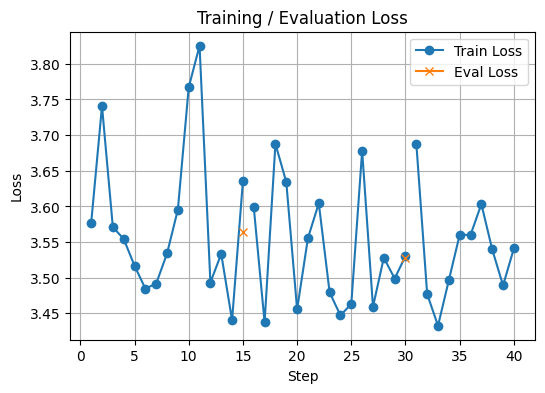

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer4.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [43]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /unsloth/medgemma-4b-it-unsloth-bnb-4bit/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000015E4F7DCE50>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: cc188fbe-1146-4752-8452-91516e9503a2)')' thrown while requesting HEAD https://huggingface.co/unsloth/medgemma-4b-it-unsloth-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /unsloth/medgemma-4b-it-unsloth-bnb-4bit/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000160F0846260>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 5a2d4283-6804-4ebd-86a2-4b727de63f39)')' thrown while requesting HEAD https://huggingface.co

✅ Model saved to: lora_model_val_idx5_20251017_093806


#5 FOLD

In [8]:
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FastVisionModel.for_training(model)

trainer5 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        # ===== core =====
        per_device_train_batch_size = 2,
        per_device_eval_batch_size  = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        seed = 3407,

        # ===== Eval =====
        eval_strategy = "steps",
        eval_steps = 15,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        # ===== Precision / dtype =====
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        # ===== Optimization =====
        learning_rate = 2e-4,
        optim = "adamw_8bit",
        weight_decay = 0.05,
        lr_scheduler_type = "constant_with_warmup",
        max_grad_norm = 0.8,

        # ===== Dataloader (สำคัญ) =====
        dataloader_num_workers = 0,      # 👈 ปิด multi-worker กันปัญหา pickle
        dataloader_pin_memory = True,
        dataloader_drop_last = False,
        # อย่าใส่ dataloader_prefetch_factor / persistent_workers เมื่อ num_workers=0

        # ===== Logging / Checkpoint IO =====
        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 5,
        save_strategy = "steps",
        save_steps = 30,
        save_total_limit = 1,
        load_best_model_at_end = False,

        # ===== Output =====
        output_dir = "outputs_Fold5",

        # ===== Vision finetuning (required) =====
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,            # 👈 กันปัญหา pickle ตอน map/prepare (ถ้ามี)
        max_seq_length = 1024,

        # ===== Memory saver =====
        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
    # เรา "ไม่" ใช้ compute_metrics ที่ระดับ SFTTrainer ตรง ๆ
    # เพราะ VLM+generate มักชนกับ _pad_across_processes; จึงย้ายไป callback
)

trainer5.predict_with_generate = True
trainer5.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

In [9]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer5)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 3,981,312 of 4,304,060,784 (0.09% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
15,3.888200,3.852983
30,3.822300,3.772959
45,3.673300,3.688708
60,3.567100,3.638683


Unsloth: Not an error, but Gemma3ForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [10]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer5.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 3.765954113006592
Final Eval Loss for this fold = 3.6387
All metrics: {'train_runtime': 4153.971, 'train_samples_per_second': 0.116, 'train_steps_per_second': 0.014, 'total_flos': 4568345441761920.0, 'train_loss': 3.765954113006592, 'epoch': 0.11136890951276102}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.8894,0.533694,0.00016,0.009281,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.8766,0.690059,0.00020,0.018561,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.8882,1.103966,0.00020,0.027842,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.027842,15,3.852983,701.8805,1.228,0.308,NaN,NaN,NaN,NaN,NaN
4,3.8559,0.635075,0.00020,0.037123,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.7746,0.539019,0.00020,0.046404,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3.8223,0.799729,0.00020,0.055684,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.055684,30,3.772959,686.4729,1.256,0.315,NaN,NaN,NaN,NaN,NaN
8,3.7662,0.814105,0.00020,0.064965,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.7504,0.895530,0.00020,0.074246,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


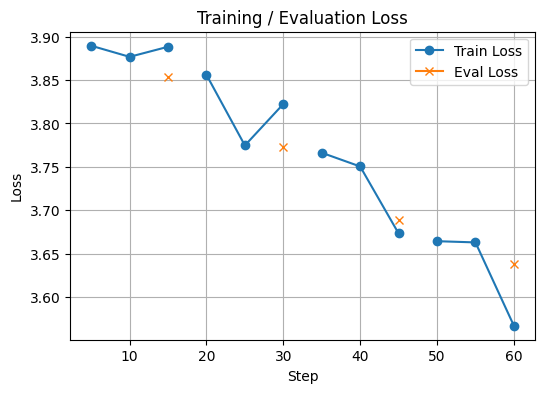

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer5.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx5_20251017_124531


#6 FOLD

In [13]:
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FastVisionModel.for_training(model)

trainer6 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        # ===== core =====
        per_device_train_batch_size = 3,
        per_device_eval_batch_size  = 6,
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        max_steps = 30,
        seed = 3407,

        # ===== Eval =====
        eval_strategy = "steps",
        eval_steps = 20,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        # ===== Precision / dtype =====
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        # ===== Optimization =====
        learning_rate = 5e-5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "constant_with_warmup",
        max_grad_norm = 1.0,

        # ===== Dataloader (สำคัญ) =====
        dataloader_num_workers = 0,      # 👈 ปิด multi-worker กันปัญหา pickle
        dataloader_pin_memory = True,
        dataloader_drop_last = False,
        # อย่าใส่ dataloader_prefetch_factor / persistent_workers เมื่อ num_workers=0

        # ===== Logging / Checkpoint IO =====
        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        # ===== Output =====
        output_dir = "outputs_Fold6",

        # ===== Vision finetuning (required) =====
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,            # 👈 กันปัญหา pickle ตอน map/prepare (ถ้ามี)
        max_seq_length = 1024,

        # ===== Memory saver =====
        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
    # เรา "ไม่" ใช้ compute_metrics ที่ระดับ SFTTrainer ตรง ๆ
    # เพราะ VLM+generate มักชนกับ _pad_across_processes; จึงย้ายไป callback
)

trainer6.predict_with_generate = True
trainer6.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

In [14]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer6)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 3 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (3 x 4 x 1) = 12
 "-____-"     Trainable parameters = 3,981,312 of 4,304,060,784 (0.09% trained)


Step,Training Loss,Validation Loss
20,3.578800,3.606862


In [15]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer6.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 3.609558852513631
Final Eval Loss for this fold = 3.6069
All metrics: {'train_runtime': 1693.9017, 'train_samples_per_second': 0.213, 'train_steps_per_second': 0.018, 'total_flos': 3460022084181312.0, 'train_loss': 3.609558852513631, 'epoch': 0.08350730688935282}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.6680,0.772053,0.000000,0.002784,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.6516,1.093294,0.000005,0.005567,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5399,1.349826,0.000010,0.008351,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.5567,1.674108,0.000015,0.011134,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.5069,0.983411,0.000020,0.013918,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.6560,0.713729,0.000025,0.016701,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3.7559,0.718704,0.000030,0.019485,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.7245,0.971933,0.000035,0.022269,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.5258,0.723558,0.000040,0.025052,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.6504,1.332100,0.000045,0.027836,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


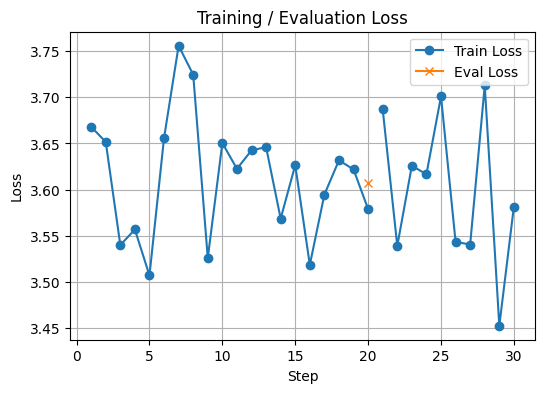

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer6.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx5_20251017_131351


Manual Eval

Fold1

In [1]:
import re, torch, pandas as pd
from tqdm import tqdm
from unsloth import FastVisionModel
from transformers import TextStreamer

# ===== 0) โหลดโมเดล + LoRA (เหมือนเดิม) =====
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/medgemma-4b-it-unsloth-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_val_idx5_20251017_131351")
FastVisionModel.for_inference(model)
model.eval()

f:\Lung-Captioning-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1017 17:15:12.061246 22636 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!


f:\Lung-Captioning-main\venv\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.11: Fast Gemma3 patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.6. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


Gemma3ForConditionalGeneration(
  (model): Gemma3Model(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(4096, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-15): 16 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.15, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1152, out_features=16, bias=False)
                  )
           

In [2]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

n = len(train_hf)
k = 6
fold_size = n // k

folds = []
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size if i < k - 1 else n
    fold = train_hf.select(range(start, end))
    folds.append(fold)

idx_selected = 0                        # ← แก้เลขในนี้ได้ตามต้องการ
val_selected = folds[idx_selected]            

print(f"Total train_hf : {n}")
print(f"Each fold size : {fold_size}")
print(val_selected)

Total dataset size : 6,085
Train set size     : 5,172 (85.00%)
Test set size      : 913 (15.00%)
Total train_hf : 5172
Each fold size : 862
Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 862
})


In [1]:
# ==========================================
# 🧠 MedGemma-4B-IT (Unsloth 4-bit) Evaluation Loop — FIXED for 6GB GPU
# ==========================================

import os, re, torch, pandas as pd
from tqdm import tqdm
from unsloth import FastVisionModel
from transformers import TextStreamer

# 🔧 GPU memory tuning (important for 6 GB)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["UNSLOTH_TARGET_GB"] = "5"  # target VRAM budget

# ------------------------------------------
# 0️⃣ Load model + tokenizer + LoRA
# ------------------------------------------
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/medgemma-4b-it-unsloth-bnb-4bit",
    load_in_4bit=True,
    device_map={
        "": "cuda:0",                  # keep most layers on GPU
        "vision_tower": "cpu",         # offload big vision encoder to CPU
        "language_model.model.embed_tokens": "cpu",
        "language_model.lm_head": "cpu",
    },
    torch_dtype=torch.bfloat16,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_val_idx5_20251017_131351")
FastVisionModel.for_inference(model)
model.eval()
print("✅ MedGemma-4B-IT loaded with hybrid GPU+CPU dispatch successfully!")

# ------------------------------------------
# 1️⃣ Dataset subset
# ------------------------------------------
subset = val_selected.select(range(30))  # evaluate only 30 samples

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

# ------------------------------------------
# 2️⃣ Class extraction helper
# ------------------------------------------
def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

# ------------------------------------------
# 3️⃣ Inference loop
# ------------------------------------------
rows = []
correct = total = 0

for i, example in enumerate(tqdm(subset, desc="Evaluating MedGemma", total=len(subset))):
    image = example["image"]
    true_class = example["__class__"]
    image_id = example.get("id", i)

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    input_len = inputs["input_ids"].shape[1]
    gen_ids = outputs[0][input_len:]
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)

    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class: {true_class}, pred_class: {pred_class}")

    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ------------------------------------------
# 4️⃣ Accuracy summary
# ------------------------------------------
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 30 samples: {acc:.4f} ({correct}/{total})")

# ------------------------------------------
# 5️⃣ Save predictions to CSV
# ------------------------------------------
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_idx{idx_selected}_medgemma.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")


f:\Lung-Captioning-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1017 18:18:18.121226 18796 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!


f:\Lung-Captioning-main\venv\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.11: Fast Gemma3 patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.6. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


`torch_dtype` is deprecated! Use `dtype` instead!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [2]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

all_train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# 85
vt = all_train_hf.train_test_split(test_size=0.17, seed=42, shuffle=True)
train_hf = vt["train"]
val_hf = vt["test"]

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Val set size       : {len(val_hf):,} ({len(val_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

Total dataset size : 6,085
Train set size     : 4,292 (70.53%)
Val set size       : 880 (14.46%)
Test set size      : 913 (15.00%)


In [4]:
instruction = (
    "You are an expert radiologist. "
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive."
)

def convert_to_conversation(sample):
    cls_name = sample["__class__"]
    description = sample["text"]

    answer = f"Class: {cls_name}\nExplanation: {description}"

    conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a medical image interpretation assistant."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]}
            ]
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": answer}]
        }
    ]

    return {"messages": conversation}

# Convert your datasets
converted_dataset = [convert_to_conversation(sample) for sample in train_hf]

converted_dataset_val = [convert_to_conversation(sample) for sample in val_hf]

converted_dataset_test = [convert_to_conversation(sample) for sample in blind_test_hf]

converted_dataset[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a medical image interpretation assistant.'}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiologist. Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x450>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Class: Degenerative_Infectious\nExplanation: The pattern of bilateral hilar lymphadenopathy (sarcoidosis) aligns with bilateral, symmetric hilar enlargement with perihilar reticulonodular changes (sarcoidosis). Possibly representing Sarcoidosis. The lymphadenopathy is notable for its symmetric distribution. Perihilar interstitial thickening is also obs

In [5]:
import re
import numpy as np
from evaluate import load

# โหลด metric BLEU เพียงครั้งเดียว
bleu = load("bleu")

# รายชื่อคลาสที่อนุญาต
ALLOWED_CLASSES = {
    "Chest_Changes",
    "Degenerative_Infectious",
    "Higher_Density",
    "Inflammatory_Pneumonia",
    "Lower_Density",
    "Mediastinal_Changes",
    "Normal",
    "Obstructive",
}

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # ===== ฟังก์ชันย่อยภายในสำหรับดึงชื่อคลาส =====
    def extract_class(text: str):
        """ดึงชื่อคลาสจากข้อความ (ถ้ามี)"""
        if not isinstance(text, str):
            return None
        for cls in ALLOWED_CLASSES:
            # ใช้ regex ค้นชื่อคลาสแบบ exact (ไม่สนข้อความอื่นรอบ ๆ)
            if re.search(rf"\b{re.escape(cls)}\b", text):
                return cls
        return None
    # ===============================================

    # แปลง token IDs เป็นข้อความ
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ดึงชื่อคลาสจาก pred และ label
    pred_classes = [extract_class(p) for p in preds]
    label_classes = [extract_class(l) for l in labels]

    # คำนวณ accuracy — นับถูกถ้าชื่อคลาสตรงกัน
    correct, total = 0, 0
    for p_cls, l_cls in zip(pred_classes, label_classes):
        if l_cls is not None:
            total += 1
            if p_cls == l_cls:
                correct += 1
    acc = correct / total if total > 0 else 0.0

    # คำนวณ BLEU score (ความใกล้เคียงข้อความ)
    bleu_score = bleu.compute(
        predictions=[[p.split()] for p in preds],
        references=[[[l.split()]] for l in labels]
    )["bleu"]

    # คืนค่า metric ทั้งคู่
    return {
        "eval_accuracy": acc,
        "eval_bleu": bleu_score,
    }

In [9]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        per_device_train_batch_size = 1,       # CHANGED
        per_device_eval_batch_size  = 2,       # CHANGED
        gradient_accumulation_steps = 8,       # CHANGED
        warmup_steps = 8,                       # CHANGED
        max_steps = 40,                         # CHANGED
        seed = 3407,

        eval_strategy = "steps",
        eval_steps = 15,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        learning_rate = 1.5e-4,                # CHANGED
        optim = "adamw_8bit",
        weight_decay = 0.0,                     # CHANGED
        lr_scheduler_type = "polynomial",       # CHANGED
        max_grad_norm = 1.0,

        dataloader_num_workers = 0,
        dataloader_pin_memory = True,
        dataloader_drop_last = False,

        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        output_dir = "outputs",            # CHANGED

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,
        max_seq_length = 2048,                  # CHANGED

        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
)

trainer.predict_with_generate = True
trainer.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

In [10]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 3060 Laptop GPU. Max memory = 6.0 GB.
3.949 GB of memory reserved.


In [11]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,292 | Num Epochs = 1 | Total steps = 40
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 3,981,312 of 4,304,060,784 (0.09% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
15,3.797000,3.900995
30,3.831200,3.862751


Unsloth: Not an error, but Gemma3ForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [12]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss   =", trainer_stats.training_loss)
print(f"Final Eval Loss = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss   = 3.855032879114151
Final Eval Loss = 3.8628
All metrics: {'train_runtime': 2700.2372, 'train_samples_per_second': 0.119, 'train_steps_per_second': 0.015, 'total_flos': 2973821781876192.0, 'train_loss': 3.855032879114151, 'epoch': 0.07455731593662628}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.8335,0.894557,0.000000,0.001864,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.9994,0.732237,0.000019,0.003728,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.1058,1.572672,0.000037,0.005592,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.7492,0.579897,0.000056,0.007456,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.8859,0.930013,0.000075,0.009320,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.9460,0.870776,0.000094,0.011184,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3.8950,0.877992,0.000112,0.013048,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.7871,0.772491,0.000131,0.014911,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.8744,0.649789,0.000150,0.016775,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.6689,0.671317,0.000145,0.018639,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


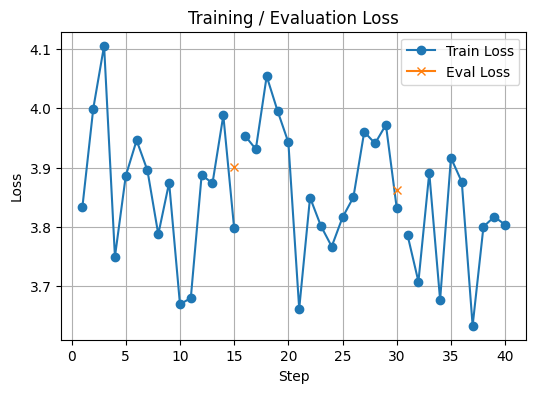

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_final_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_final_20251017_191115


In [15]:
final_eval = trainer.evaluate(converted_dataset_test)
print(final_eval)

{'eval_loss': 3.8440287113189697, 'eval_runtime': 840.157, 'eval_samples_per_second': 1.087, 'eval_steps_per_second': 0.544, 'epoch': 0.07455731593662628}


In [16]:
import re, torch, pandas as pd
from tqdm import tqdm

# ===== 1) ใช้แค่ 30 ตัวแรก =====
subset = blind_test_hf.select(range(30))

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    # 1) จับจาก "Class: <ชื่อคลาส>" ก่อน (multi-line, case-insensitive)
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        # ไม่สนพิมพ์เล็กใหญ่ แต่คืนชื่อมาตรฐาน
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    # 2) Fallback: ถ้าจำเป็นจริง ๆ ค่อยสแกนทั้งข้อความ (เลี่ยง prompt echo)
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

rows = []
correct = total = 0

for i, example in enumerate(subset):
    image = example["image"]

    # label จริงมาจาก __class__
    true_class = example["__class__"]

    # image_id (ถ้าไม่มีคอลัมน์ id ใช้ดัชนี i)
    image_id = example.get("id", i)

    # [changed] ส่ง instruction เดียวกันทุกภาพเข้า chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    # ตัด prompt ออก: ใช้ความยาว input_ids เป็นตัวแบ่ง
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[0][input_len:]                 # <-- เฉพาะที่โมเดลสร้างใหม่
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class : {true_class}, pred_class : {pred_class}")

    # อัปเดต accuracy (นับเมื่อ true_class เป็นคลาสใน ALLOWED_CLASSES)
    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ===== 2) สรุป accuracy =====
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 30 samples: {acc:.4f} ({correct}/{total})")

# ===== 3) เซฟ CSV =====
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_final.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")

id: 0, true_class : Degenerative_Infectious, pred_class : Inflammatory_Pneumonia
id: 1, true_class : Mediastinal_Changes, pred_class : Mediastinal_Changes
id: 2, true_class : Mediastinal_Changes, pred_class : Mediastinal_Changes
id: 3, true_class : Obstructive, pred_class : Normal
id: 4, true_class : Higher_Density, pred_class : None
id: 5, true_class : Obstructive, pred_class : Inflammatory_Pneumonia
id: 6, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 7, true_class : Normal, pred_class : Normal
id: 8, true_class : Obstructive, pred_class : Normal
id: 9, true_class : Degenerative_Infectious, pred_class : Inflammatory_Pneumonia
id: 10, true_class : Normal, pred_class : Normal
id: 11, true_class : Lower_Density, pred_class : Normal
id: 12, true_class : Inflammatory_Pneumonia, pred_class : Obstructive
id: 13, true_class : Normal, pred_class : Normal
id: 14, true_class : Mediastinal_Changes, pred_class : Lower_Density
id: 15, true_class : Obstructive, pred_c